In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from statistics import mean
from statistics import stdev
import os
plt.rcParams["figure.figsize"] = [15, 5]
big = 1.0

In [2]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    #ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("white", "black"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def create_feature_tradeoff_map(gamma):
  base_path = "/content/drive/MyDrive/Code/AI4LIFE/Fairness vs Complexity/results/real_data/"
  files = read_files('german_credit_heatmap_gammas')
  #ks = 10,20,30,40,50,60,70 => k=10 -> i = 0
  ks = [10,20,30,40,50,60,70]#,50,60,70]
  data = np.array([])
  counter = 0
  
  for file in files:
    dat = np.load(base_path + file)
    dat = dat[(dat[:,3] == gamma)]
    if counter==0:
      data = dat
    else:
      data = np.vstack((data,dat))
    counter+=1
  base_acc, base_fair = get_acc_fair_by_feature(10,data)
  map = np.zeros((7, 7))
  for i,a in zip(ks, np.arange(0,7,1)): # cols
    for j,b in zip(ks, np.arange(6,-1,-1)): #rows
      acc,fair = get_acc_feature_tradeoff(i,j,data)
      if i < j:
        map[b][a] = round(acc,2)
        #print(str(b)+","+str(a) + "acc")
      if i >= j:
        map[b][a] = round(fair*(-1),2)
        #print(str(b)+","+str(a)+ "fair")
  return map, base_acc, base_fair


def plot_feature_heatmap(gamma):
  gammas1 = ["70","60","50","40","30","20", "10"]#, "30", "20", "10"]

  gammas2 = ["10","20","30","40","50","60","70"]

  values,base_acc,base_fair = create_feature_tradeoff_map(gamma)
  fig, ax = plt.subplots()

  im, cbar = heatmap(values, gammas1, gammas2, ax=ax,cmap="YlGn", cbarlabel="ACC/Fairnes gain in ppt",vmin=-0.1, vmax=0.1)
  texts = annotate_heatmap(im, valfmt="{x:.2f}")
  plt.xlabel("Fairness Tradeoff")
  plt.ylabel("Accuracy Tradeoff")
  plt.title("Gamma = "+str(gamma) + " German Credit"+'\n'+"Acc@10Features: "+str(round(base_acc,3)) + '\n'+ "ErrDiff@10Features: "+str(round(base_fair,3)))
  fig.tight_layout()
  plt.show()

(<matplotlib.image.AxesImage at 0x7fa40a5f4510>,
 <matplotlib.colorbar.Colorbar at 0x7fa40a6a1150>)

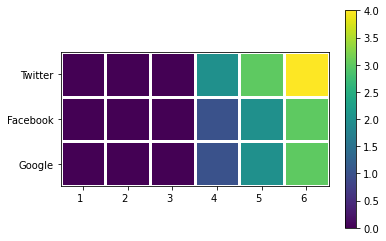

In [ ]:
heatmap(np.array([[0,0,0,2,3,4],
         [0,0,0,1,2,3],
         [0,0,0,1,2,3]]), np.array(['Twitter','Facebook','Google']), np.array(['1','2','3','4','5','6']))

In [20]:
import json
from datetime import datetime

with open('/content/drive/MyDrive/Code/HIIG/pgArchive/data/json/platforms.json') as json_file:
  data = json.load(json_file)

In [21]:
def get_dates(company, policy, data=data):
  for i in range(0,len(data)):
    c = data[i]['name']
    if c == company:
       for j in range(0,len(data[i]['policies'])):
          p =  data[i]['policies'][j]['name']
          if p == policy:
            #print(p)
            return data[i]['policies'][j]['dates']
  return 0

In [22]:
def get_word_count_of_date(company,policy,date, data=data):
  for i in range(0,len(data)):
    c = data[i]['name']
    if c == company:
       for j in range(0,len(data[i]['policies'])):
          p =  data[i]['policies'][j]['name']
          if p == policy:
            texts = data[i]['policies'][j]['diffchecks']
            for t in texts:
              if t['dateNew'] == date:
                return len(t['mdNew'])
  return 0

In [41]:
np.zeros(1)

array([0.])

In [135]:
def create_xy(list_of_dates, min_year=2007, max_year=2021, dim=3):
  y = np.zeros((dim,(((max_year+1)-min_year)*2)))
  for i in range(0,len(list_of_dates)):
    for d in list_of_dates[i]:
      #print(d)
      date_time_obj = datetime.strptime(d, '%Y%m%d') 
      row = i
      if date_time_obj.year < min_year:
        continue
      col = date_time_obj.year-min_year
      if date_time_obj.month < 7 and col >0:
        col = col*2
      elif date_time_obj.month >= 7 and col >0:
        col = (2*col)+1
      elif col == 0 and date_time_obj.month >=7:
        col = col+1
      # print("row"+str(row) + " - col:"+str(col))
      # print(y.shape)
      y[row][col] +=1

  x= []
  for i in range(min_year, max_year+1):
    x.append(str(i)+"/"+str(1))
    x.append(str(i)+"/"+str(2))
  #x.append('2021/1')
  return np.array(x),y

def create_xy_wordcount(list_of_dates, min_year=2007, max_year=2021, dim=3, comps = ['Facebook', 'Instagram', 'Twitter', 'YouTube']
                        , policies=['Community Guidelines', 'Terms of Service', 'Privacy Policy']):
  y = np.zeros((dim,(((max_year+1)-min_year)*2)))
  doccount = np.zeros((dim,(((max_year+1)-min_year)*2)))
  for i in range(0,len(list_of_dates)):
    for d in list_of_dates[i]:
      #print(d)
      date_time_obj = datetime.strptime(d, '%Y%m%d') 
      row = i
      if date_time_obj.year < min_year:
        continue
      col = date_time_obj.year-min_year
      if date_time_obj.month < 7 and col >0:
        col = (col*2)
      elif date_time_obj.month >= 7 and col >0:
        col = (2*col)+1
      elif date_time_obj.month > 7 and col ==0:
        col = col+1
      # print("row"+str(row) + " - col:"+str(col))
      # print(y.shape)
      company = comps[i]
      for p in policies: 
        v = get_word_count_of_date(company,p,d)
        y[row][col] += v
        if v>0:
          doccount[row][col]+=1
  for i in range(0,y.shape[0]):
    for j in range(0,y.shape[1]):
      y[i][j] = y[i][j]/max(1,doccount[i][j])
      y[i][j] = y[i][j]/10000 
  x= []
  for i in range(min_year, max_year+1):
    x.append(str(i)+"/"+str(1))
    x.append(str(i)+"/"+str(2))
  #x.append('2022/1')
  #print(x)
  return np.array(x),y, doccount

def create_xy_wordcount_per_quater(list_of_dates, min_year=2007, max_year=2021, dim=3, comps = ['Facebook', 'Instagram', 'Twitter', 'YouTube']
                        , policies=['Community Guidelines', 'Terms of Service', 'Privacy Policy'], mode='single_company'):
  y = np.zeros((dim,(((max_year+1)-min_year)*4)))
  doccount = np.zeros((dim,(((max_year+1)-min_year)*4)))
  for i in range(0,len(list_of_dates)):
    for d in list_of_dates[i]:
      #print(d)
      date_time_obj = datetime.strptime(d, '%Y%m%d') 
      row = i
      if date_time_obj.year < min_year:
        continue
      col = date_time_obj.year-min_year
      if date_time_obj.month in [1,2,3]:
        col = (col*4)
      elif date_time_obj.month in [4,5,6]:
        col = (col*4)+1
      elif date_time_obj.month in [7,8,9]:
        col = (col*4)+2
      elif date_time_obj.month in [10,11,12]:
        col = (col*4)+3
        #col = col+1
      # print("row"+str(row) + " - col:"+str(col))
      # print(y.shape)
      if mode == 'single_company':
        company = comps[0]
      else:
        company = comps[i]
      for p in policies: 
        v = get_word_count_of_date(company,p,d)
        y[row][col] += v
        if v>0:
          doccount[row][col]+=1
  for i in range(0,y.shape[0]):
    for j in range(0,y.shape[1]):
      y[i][j] = y[i][j]/max(1,doccount[i][j])
      # y[i][j] = y[i][j]/10000 
  x= []
  for i in range(min_year, max_year+1):
    x.append(str(i)+"/"+str(1))
    x.append(str(i)+"/"+str(2))
    x.append(str(i)+"/"+str(3))
    x.append(str(i)+"/"+str(4))
  #x.append('2022/1')
  #print(x)
  return np.array(x),y, doccount

In [26]:
np.sort(get_dates('Facebook', 'Terms of Service'))

array(['20040611', '20040827', '20050630', '20050826', '20051126',
       '20060103', '20060301', '20061031', '20061218', '20070630',
       '20071219', '20080719', '20081029', '20090204', '20090603',
       '20090902', '20091117', '20100205', '20100312', '20100430',
       '20100828', '20101005', '20101209', '20110428', '20110602',
       '20110630', '20110901', '20120613', '20121214', '20131118',
       '20150202', '20150623', '20170518', '20180526', '20190803',
       '20201017', '20201024', '20211030'], dtype='<U8')

#Plot Heatmap

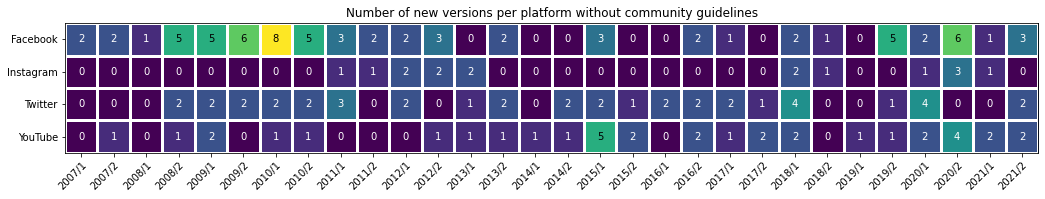

In [145]:
d1 = get_dates('Facebook', 'Terms of Service') + get_dates('Facebook', 'Privacy Policy') 
d2 =get_dates('Instagram', 'Terms of Service') + get_dates('Instagram', 'Privacy Policy')
d3 =get_dates('Twitter', 'Terms of Service') + get_dates('Twitter', 'Privacy Policy')
d4 = get_dates('YouTube', 'Terms of Service') + get_dates('YouTube', 'Privacy Policy')
x,y = create_xy([d1,d2,d3,d4], dim=4)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter','YouTube']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("Number of new versions per platform without community guidelines")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/aggregated_policy_changes_wo_cg_with_youtube.svg')
plt.show()

##By platform

In [ ]:
#Heatmap "New policy versions per semester Facebook" (Terms of Service, Privacy Policy, Community Guidelines) 
d1 = get_dates('Facebook', 'Community Guidelines') + get_dates('Facebook', 'Terms of Service')
d2 = get_dates('Facebook', 'Terms of Service')
d3 = get_dates('Facebook', 'Privacy Policy')
x,y = create_xy([d1,d2,d3], dim=3)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Community Guidelines','Terms of Service','Privacy Policy']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions per Policy: Facebook")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_policy_versions_facebook.svg')
plt.show()

###Facebook

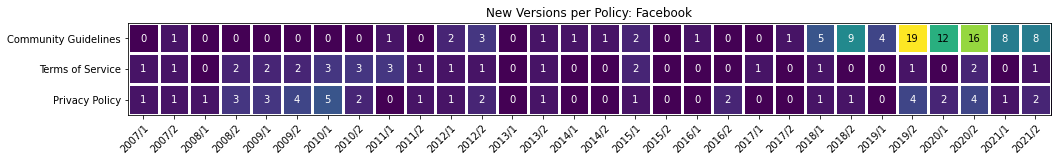

In [79]:
#Heatmap "New policy versions per semester Facebook" (Terms of Service, Privacy Policy, Community Guidelines) 
d1 = get_dates('Facebook', 'Community Guidelines')
d2 = get_dates('Facebook', 'Terms of Service')
d3 = get_dates('Facebook', 'Privacy Policy')
x,y = create_xy([d1,d2,d3], dim=3)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Community Guidelines','Terms of Service','Privacy Policy']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions per Policy: Facebook")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_policy_versions_facebook.svg')
plt.show()

###YouTube

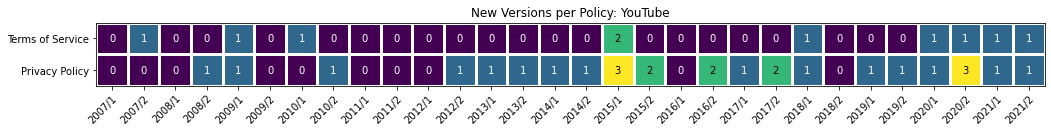

In [80]:
#Heatmap "New policy versions per semester Facebook" (Terms of Service, Privacy Policy, Community Guidelines) 
#d1 = get_dates('YouTube', 'Community Guidelines')
d2 = get_dates('YouTube', 'Terms of Service')
d3 = get_dates('YouTube', 'Privacy Policy')
x,y = create_xy([d2,d3], dim=2)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Terms of Service','Privacy Policy']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions per Policy: YouTube")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_policy_versions_youtube.svg')
plt.show()

###Twitter

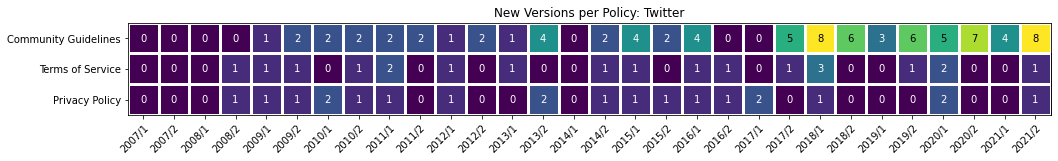

In [81]:
#Heatmap "New policy versions per semester Facebook" (Terms of Service, Privacy Policy, Community Guidelines) 
d1 = get_dates('Twitter', 'Community Guidelines')
d2 = get_dates('Twitter', 'Terms of Service')
d3 = get_dates('Twitter', 'Privacy Policy')
x,y = create_xy([d1,d2,d3], dim=3)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Community Guidelines','Terms of Service','Privacy Policy']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions per Policy: Twitter")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_policy_versions_twitter.svg')
plt.show()

###Instagram

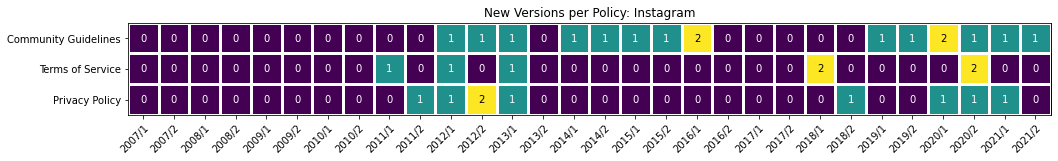

In [82]:
#Heatmap "New policy versions per semester Facebook" (Terms of Service, Privacy Policy, Community Guidelines) 
d1 = get_dates('Instagram', 'Community Guidelines')
d2 = get_dates('Instagram', 'Terms of Service')
d3 = get_dates('Instagram', 'Privacy Policy')
x,y = create_xy([d1,d2,d3], dim=3)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Community Guidelines','Terms of Service','Privacy Policy']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions per Policy: Instagram")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_policy_versions_instagram.svg')
plt.show()

##By policy

### Terms of Service

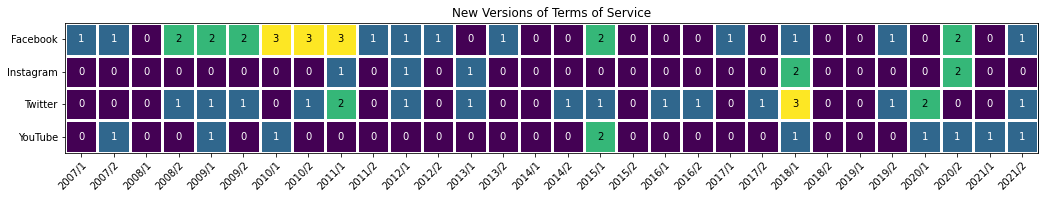

In [83]:
d1 = get_dates('Facebook', 'Terms of Service') 
d2 = get_dates('Instagram', 'Terms of Service')
d3 = get_dates('Twitter', 'Terms of Service')
d4 = get_dates('YouTube', 'Terms of Service')
x,y = create_xy([d1,d2,d3,d4], dim=4)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions of Terms of Service")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_versions_terms_of_service.svg')
plt.show()

###Privacy Policy

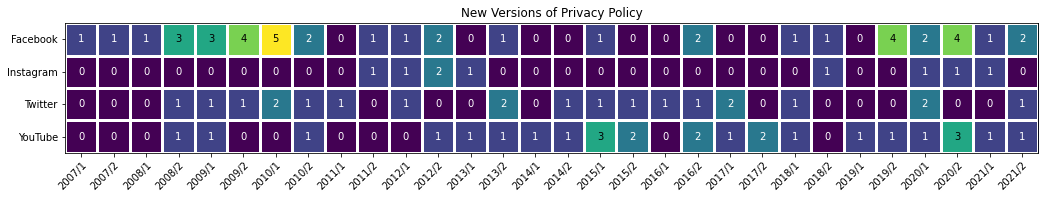

In [84]:
d1 = get_dates('Facebook', 'Privacy Policy') 
d2 = get_dates('Instagram', 'Privacy Policy')
d3 = get_dates('Twitter', 'Privacy Policy')
d4 = get_dates('YouTube', 'Privacy Policy')
x,y = create_xy([d1,d2,d3,d4], dim=4)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions of Privacy Policy")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_versions_privacy_policy.svg')
plt.show()

###Community Guidelines

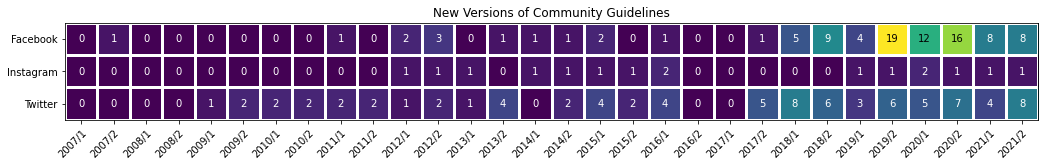

In [85]:
d1 = get_dates('Facebook', 'Community Guidelines') 
d2 = get_dates('Instagram', 'Community Guidelines')
d3 = get_dates('Twitter', 'Community Guidelines')
x,y = create_xy([d1,d2,d3], dim=3)
plt.rcParams["figure.figsize"] = [18, 8]
fig, ax = plt.subplots()

im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter']),x)
texts = annotate_heatmap(im, valfmt="{x:.2g}")
plt.title("New Versions of Community Guidelines")
fig.tight_layout()
fig.axes[1].set_visible(False)
plt.xticks(rotation = 45)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/new_versions_community_guidelines.svg')
plt.show()

##Wordcount over Time

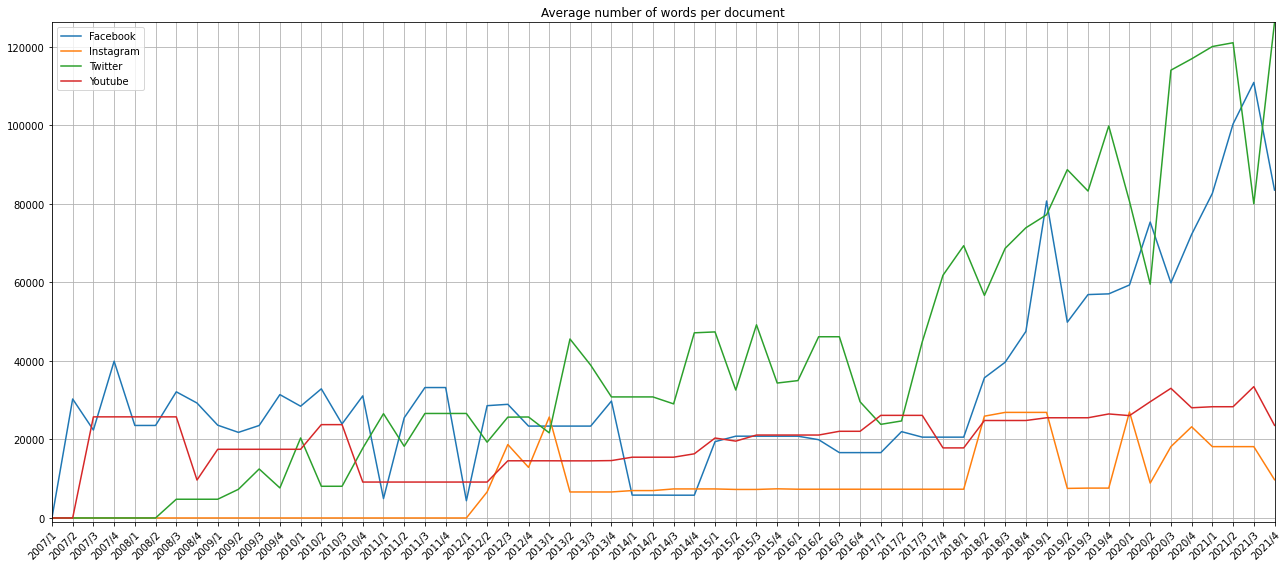

In [151]:
d1 = get_dates('Facebook', 'Community Guidelines') + get_dates('Facebook', 'Terms of Service') + get_dates('Facebook', 'Privacy Policy') 
d2 = get_dates('Instagram', 'Community Guidelines')+ get_dates('Instagram', 'Terms of Service') + get_dates('Instagram', 'Privacy Policy')
d3 = get_dates('Twitter', 'Community Guidelines')+ get_dates('Twitter', 'Terms of Service') + get_dates('Twitter', 'Privacy Policy')
d4 = get_dates('YouTube', 'Terms of Service') + get_dates('YouTube', 'Privacy Policy')
# x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3,d4], dim=4,mode='a')

# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Facebook')
plt.plot(x,y[1], label='Instagram')
plt.plot(x,y[2], label='Twitter')
plt.plot(x,y[3], label='Youtube')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[2])])
plt.legend()
plt.title('Average number of words per document')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_all.svg')
plt.show()

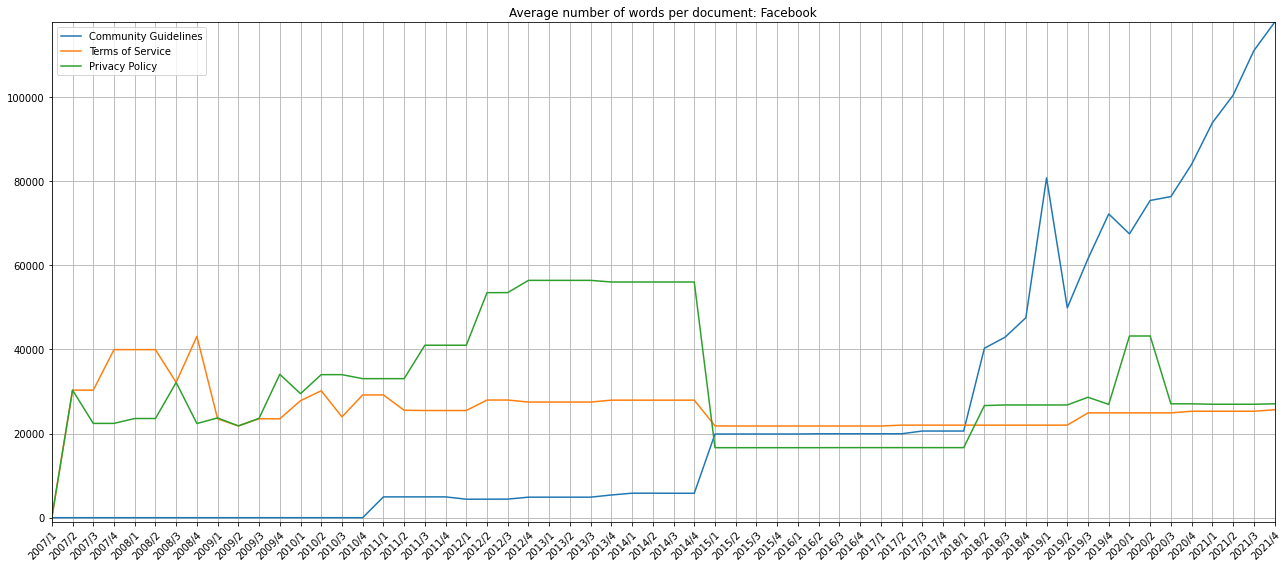

In [152]:
d1 = get_dates('Facebook', 'Community Guidelines')
d2 = get_dates('Facebook', 'Terms of Service')
d3 = get_dates('Facebook', 'Privacy Policy') 
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3], dim=3, comps=['Facebook'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Community Guidelines')
plt.plot(x,y[1], label='Terms of Service')
plt.plot(x,y[2], label='Privacy Policy')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[0])])
plt.legend()
plt.title('Average number of words per document: Facebook')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_facebook.svg')
plt.show()

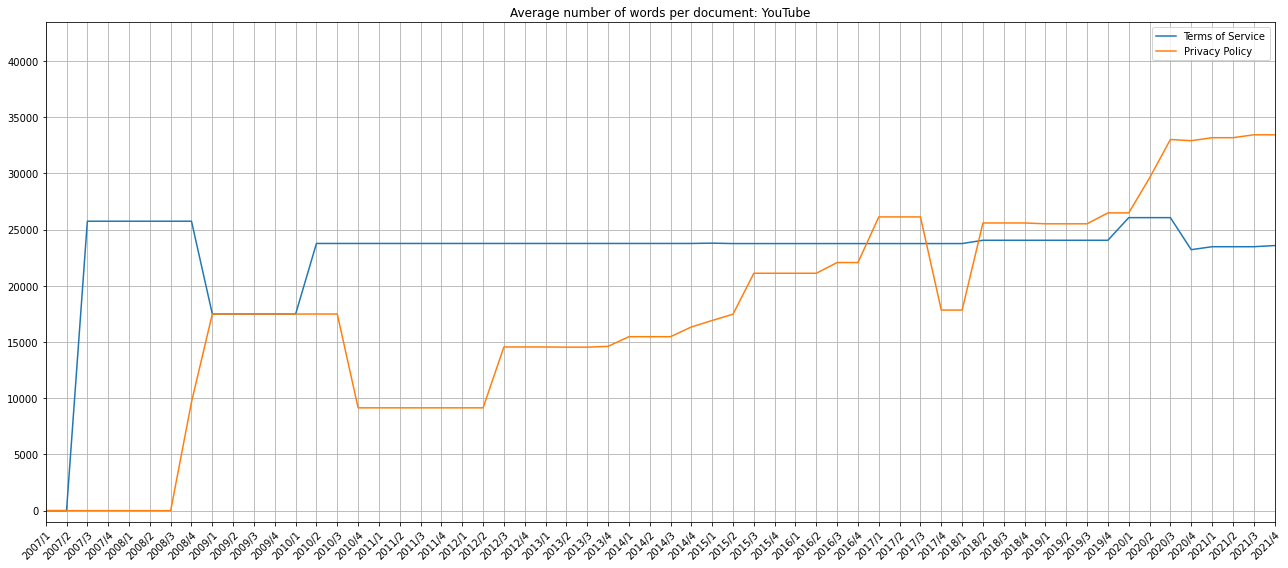

In [153]:
d2 = get_dates('YouTube', 'Terms of Service')
d3 = get_dates('YouTube', 'Privacy Policy') 
x,y,doccount = create_xy_wordcount_per_quater([d2,d3], dim=2, comps=['YouTube'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Terms of Service')
plt.plot(x,y[1], label='Privacy Policy')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[1])+10000])
plt.legend()
plt.title('Average number of words per document: YouTube')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_youtube.svg')
plt.show()

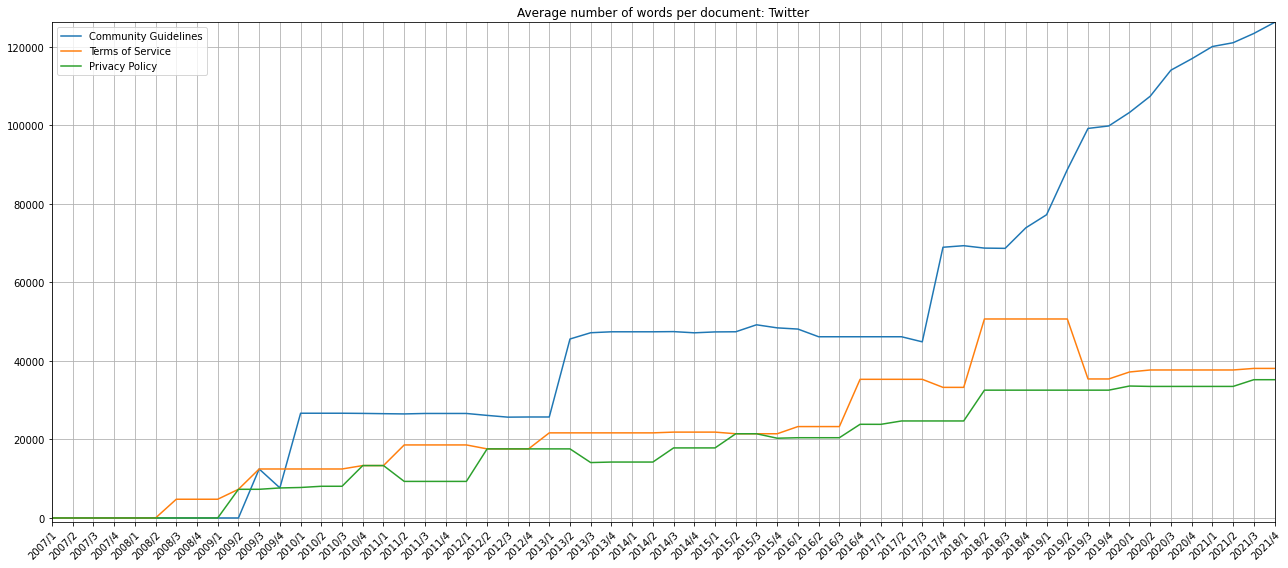

In [154]:
d1 = get_dates('Twitter', 'Community Guidelines')
d2 = get_dates('Twitter', 'Terms of Service')
d3 = get_dates('Twitter', 'Privacy Policy') 
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3], dim=3, comps=['Twitter'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Community Guidelines')
plt.plot(x,y[1], label='Terms of Service')
plt.plot(x,y[2], label='Privacy Policy')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[0])])
plt.legend()
plt.title('Average number of words per document: Twitter')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_twitter.svg')
plt.show()

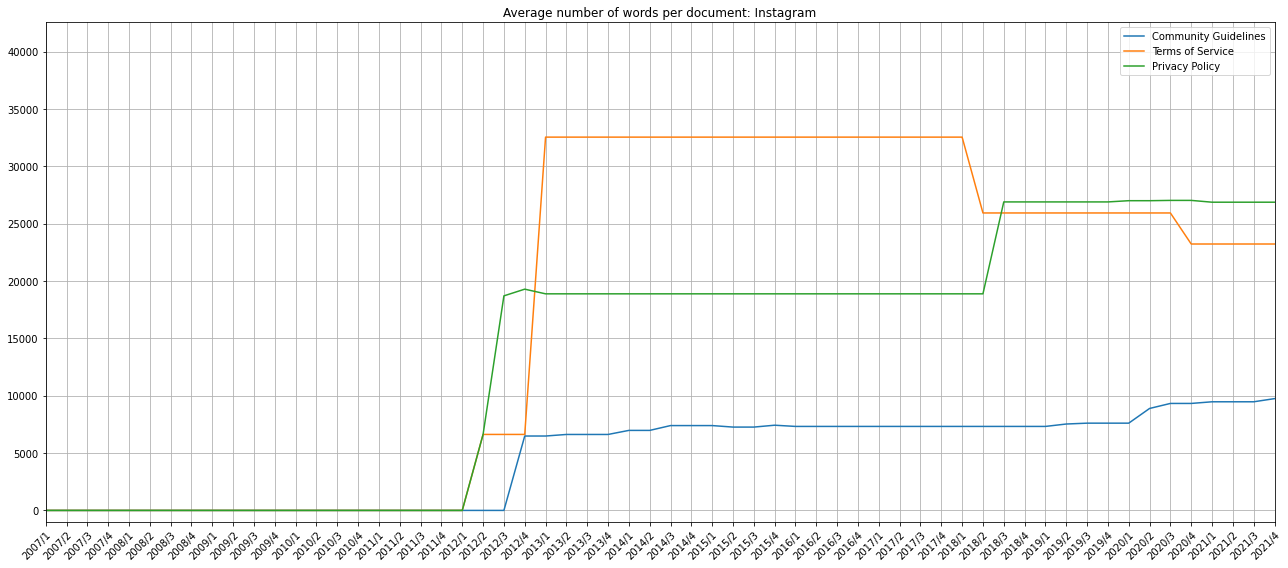

In [155]:
d1 = get_dates('Instagram', 'Community Guidelines')
d2 = get_dates('Instagram', 'Terms of Service')
d3 = get_dates('Instagram', 'Privacy Policy') 
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3], dim=3, comps=['Instagram'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Community Guidelines')
plt.plot(x,y[1], label='Terms of Service')
plt.plot(x,y[2], label='Privacy Policy')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[1])+10000])
plt.legend()
plt.title('Average number of words per document: Instagram')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_instagram.svg')
plt.show()

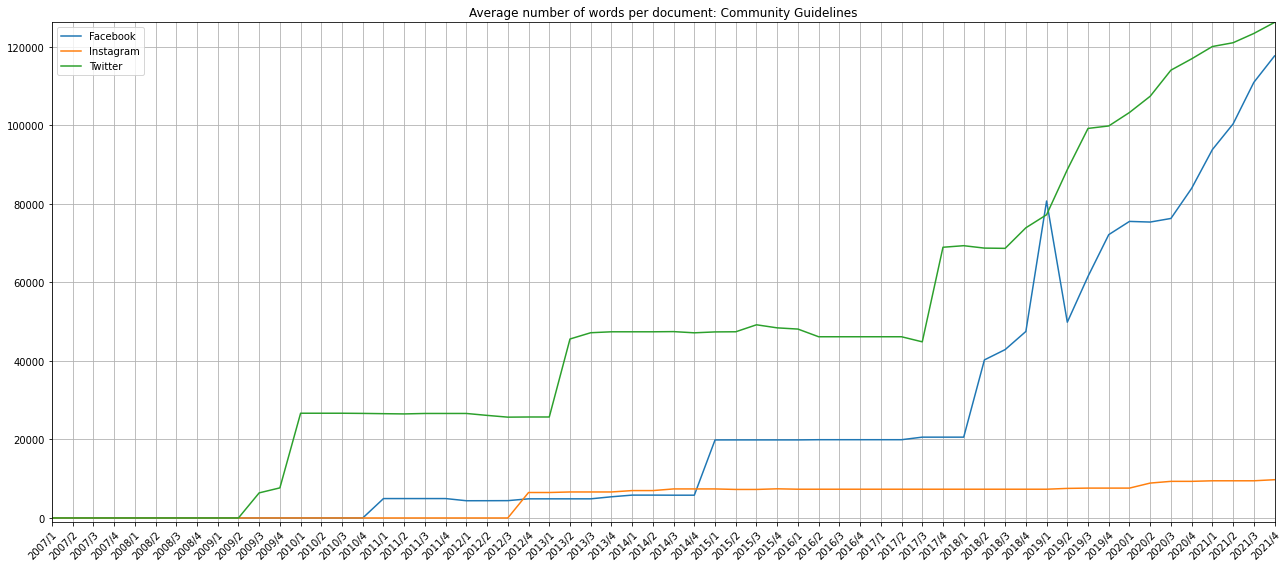

In [156]:
d1 = get_dates('Facebook', 'Community Guidelines')
d2 = get_dates('Instagram', 'Community Guidelines')
d3 = get_dates('Twitter', 'Community Guidelines')
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3], dim=3, mode='mult', comps=['Facebook', 'Instagram', 'Twitter'], policies=['Community Guidelines'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Facebook')
plt.plot(x,y[1], label='Instagram')
plt.plot(x,y[2], label='Twitter')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[2])])
plt.legend()
plt.title('Average number of words per document: Community Guidelines')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_community_guidelines.svg')
plt.show()

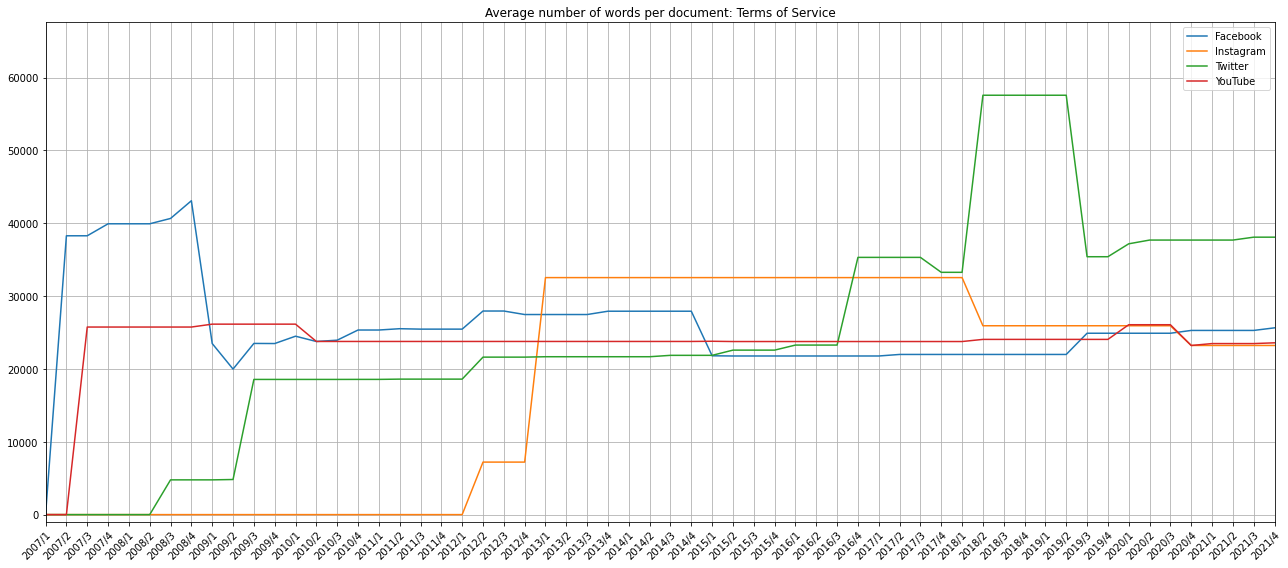

In [157]:
d1 = get_dates('Facebook', 'Terms of Service')
d2 = get_dates('Instagram', 'Terms of Service')
d3 = get_dates('Twitter', 'Terms of Service')
d4 = get_dates('YouTube', 'Terms of Service')
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3,d4], dim=4, mode='mult', comps=['Facebook', 'Instagram', 'Twitter', 'YouTube'], policies=['Terms of Service'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Facebook')
plt.plot(x,y[1], label='Instagram')
plt.plot(x,y[2], label='Twitter')
plt.plot(x,y[3], label='YouTube')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[2])+10000])
plt.legend()
plt.title('Average number of words per document: Terms of Service')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_terms_of_service.svg')
plt.show()

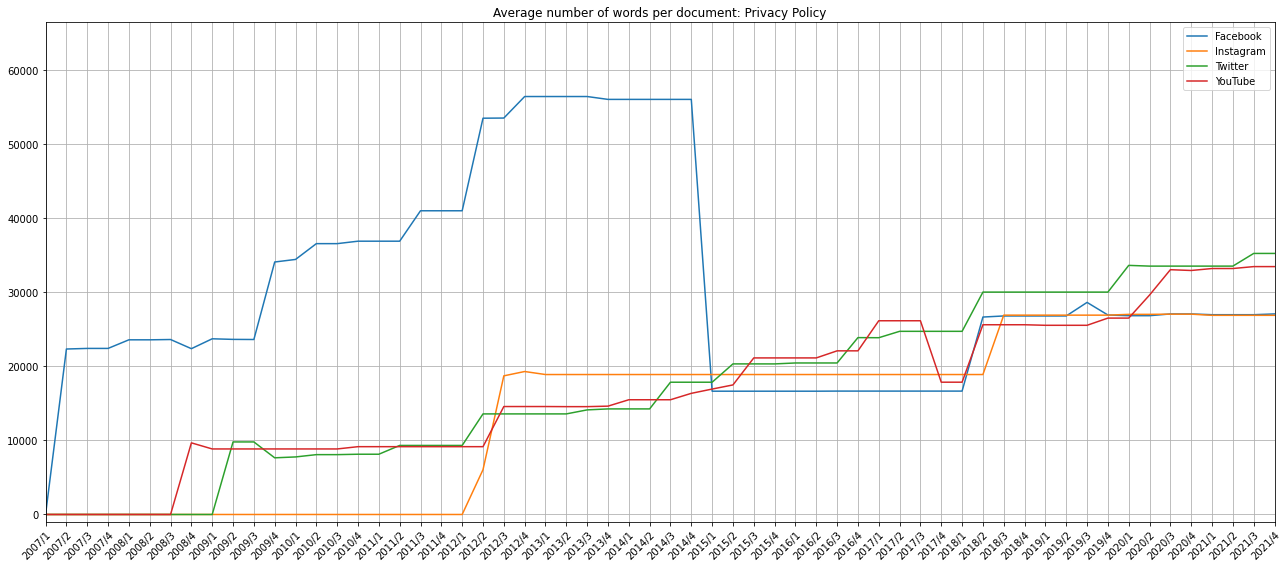

In [158]:
d1 = get_dates('Facebook', 'Privacy Policy')
d2 = get_dates('Instagram', 'Privacy Policy')
d3 = get_dates('Twitter', 'Privacy Policy')
d4 = get_dates('YouTube', 'Privacy Policy')
x,y,doccount = create_xy_wordcount_per_quater([d1,d2,d3,d4], dim=4, mode='mult', comps=['Facebook', 'Instagram', 'Twitter', 'YouTube'], policies=['Privacy Policy'])
for linie in y:
  last_real_value = 0
  for i in range(0,len(linie)):
    if linie[i] > 0:
      last_real_value = linie[i]
    if linie[i] == 0:
      linie[i] = last_real_value
# plt.plot(np.arange(0,len(x)),y[0], label='Facebook')
# plt.plot(np.arange(0,len(x)),y[1], label='Instagram')
# plt.plot(np.arange(0,len(x)),y[2], label='Twitter')
# plt.plot(np.arange(0,len(x)),y[3], label='Youtube')
plt.plot(x,y[0], label='Facebook')
plt.plot(x,y[1], label='Instagram')
plt.plot(x,y[2], label='Twitter')
plt.plot(x,y[3], label='YouTube')
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.xlim([0, max(np.arange(0,len(x)))])
plt.ylim([-1000, max(y[0])+10000])
plt.legend()
plt.title('Average number of words per document: Privacy Policy')
plt.tight_layout()
plt.grid()
#plt.subplots_adjust(left=0.0, right=0.0)
plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/words_over_time_privacy_policy.svg')
plt.show()

#Old

In [159]:
# d1 = get_dates('Facebook', 'Community Guidelines') + get_dates('Facebook', 'Terms of Service') + get_dates('Facebook', 'Privacy Policy') 
# d2 = get_dates('Instagram', 'Community Guidelines')+ get_dates('Instagram', 'Terms of Service') + get_dates('Instagram', 'Privacy Policy')
# d3 = get_dates('Twitter', 'Community Guidelines')+ get_dates('Twitter', 'Terms of Service') + get_dates('Twitter', 'Privacy Policy')
# d4 = get_dates('YouTube', 'Terms of Service') + get_dates('YouTube', 'Privacy Policy')
# x,y,doccount = create_xy_wordcount([d1,d2,d3,d4], dim=4)
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("Average number of words per document (in 10k words)")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/all_documents_changes.svg')
# plt.show()

In [160]:
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# # im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("All Documents Wordcount in 10k words")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/all_documents_changes.svg')
# plt.show()

In [161]:
# d1 = get_dates('Facebook', 'Community Guidelines') + get_dates('Facebook', 'Terms of Service') + get_dates('Facebook', 'Privacy Policy') 
# d2 = get_dates('Instagram', 'Community Guidelines')+ get_dates('Instagram', 'Terms of Service') + get_dates('Instagram', 'Privacy Policy')
# d3 = get_dates('Twitter', 'Community Guidelines')+ get_dates('Twitter', 'Terms of Service') + get_dates('Twitter', 'Privacy Policy')
# #d4 = get_dates('YouTube', 'Terms of Service') + get_dates('YouTube', 'Privacy Policy')
# x,y = create_xy([d1,d2,d3], dim=3)
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("All Documents")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/all_documents_changes.svg')
# plt.show()

In [162]:
# d1 = get_dates('Facebook', 'Terms of Service') + get_dates('Facebook', 'Privacy Policy') 
# d2 = get_dates('Instagram', 'Terms of Service') + get_dates('Instagram', 'Privacy Policy')
# d3 = get_dates('Twitter', 'Terms of Service') + get_dates('Twitter', 'Privacy Policy')
# d4 = get_dates('YouTube', 'Terms of Service') + get_dates('YouTube', 'Privacy Policy')
# x,y = create_xy([d1,d2,d3,d4], dim=4)
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("All Documents w/o Community Guidelines")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/all_documents_changes_withOut_communityGuidelines.svg')
# plt.show()

In [163]:
# d1 = get_dates('Facebook', 'Terms of Service')
# d2 = get_dates('Instagram', 'Terms of Service')
# d3 = get_dates('Twitter', 'Terms of Service')
# d4 = get_dates('YouTube', 'Terms of Service')
# x,y = create_xy([d1,d2,d3,d4], dim=4)
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# im, cbar = heatmap(y, np.array(['Facebook','Instagram','Twitter', 'YouTube']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("Terms of Service")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/terms_of_service_changes.svg')
# plt.show()

In [164]:
# d1 = get_dates('Facebook', 'Terms of Service')
# d2 = get_dates('Facebook', 'Privacy Policy')
# d3 = get_dates('Facebook', 'Community Guidelines')
# #d4 = get_dates('YouTube', 'Terms of Service')
# x,y = create_xy([d1,d2,d3], dim=3)
# plt.rcParams["figure.figsize"] = [18, 8]
# fig, ax = plt.subplots()

# im, cbar = heatmap(y, np.array(['Terms of Service','Privacy Policy','Community Guidelines']),x)
# texts = annotate_heatmap(im, valfmt="{x:.2g}")
# plt.title("Facebook")
# fig.tight_layout()
# fig.axes[1].set_visible(False)
# plt.xticks(rotation = 45)
# plt.savefig('/content/drive/MyDrive/Code/HIIG/plots/test.svg')
# plt.show()